In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_doh, blob_log

import torch
from torch import nn
from torchvision import transforms as pth_transforms

from PIL import Image

import vision_transformer as vits

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

%config InlineBackend.figure_format = 'retina'

# Load Dataset

In [2]:
df = pd.read_csv('jacks5to8.csv', index_col=0)
df.time = pd.to_datetime(df.time)
df = df
df

,filename,time
0,./data/images/2021-07-12 07:35:03-07:00.png,2021-07-12 07:35:03-07:00
1,./data/images/2021-07-12 07:36:03-07:00.png,2021-07-12 07:36:03-07:00
2,./data/images/2021-07-12 07:37:03-07:00.png,2021-07-12 07:37:03-07:00
3,./data/images/2021-07-12 07:38:03-07:00.png,2021-07-12 07:38:03-07:00
4,./data/images/2021-07-12 07:39:03-07:00.png,2021-07-12 07:39:03-07:00
...,...,...
193,./data/images/2021-07-12 07:00:57-07:00.png,2021-07-12 07:00:57-07:00
194,./data/images/2021-07-12 07:01:57-07:00.png,2021-07-12 07:01:57-07:00
195,./data/images/2021-07-12 07:02:57-07:00.png,2021-07-12 07:02:57-07:00
196,./data/images/2021-07-12 07:03:57-07:00.png,2021-07-12 07:03:57-07:00


## Load model

In [3]:
arch = 'vit_small'
patch_size = 8
pretrained_weights = 'vit_small'
checkpoint_key = None
image_path = './data/images/'

# image_size = (592, 1184)
output_dir = '.'
threshold = None

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[arch](patch_size=patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(pretrained_weights):
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    if checkpoint_key is not None and checkpoint_key in state_dict:
        print(f"Take key {checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if arch == "vit_small" and patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif arch == "vit_small" and patch_size == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif arch == "vit_base" and patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif arch == "vit_base" and patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [5]:
def load_image(file, image_size=(592, 1184), transform=True):
    '''loads picture and applies torch transforms'''
    img = Image.open(file)
    img = img.convert('RGB')
    
    if transform:
        transform = pth_transforms.Compose([
            pth_transforms.Resize(image_size),
            pth_transforms.ToTensor(),
            pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        img = transform(img)
    else:
        img = img.resize((image_size[1], image_size[0]))
    
    return img

In [6]:
def patch_image(img, patch_size):
    '''Reshapes image to be divisible by the patch size'''
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size
    
    return img, w_featmap, h_featmap

In [7]:
def mask_image(img, patch_size):
    '''Passes image through model and returns attention mask'''
    img, w_featmap, h_featmap = patch_image(img, patch_size)
    attentions = model.get_last_selfattention(img.to(device))
    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    heatmap = attentions[0, :, 0, 1:].reshape(nh, -1)
    heatmap = heatmap.reshape(nh, w_featmap, h_featmap)
    
    # interpolate attention mask back to original image size
    heatmap = nn.functional.interpolate(heatmap.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
    
    return heatmap.sum(0).astype('double')

In [8]:
def get_blobs(heatimg):
    '''
    predicts the number of surfers as the number of 
    blobs found in the attention mask of an image
    '''
    blobs = blob_doh(heatimg*256, threshold=0.05, min_sigma = 10, max_sigma=50)
    
    return blobs

In [9]:
def predict(row, patch_size=8):
    img = load_image(row['filename'])
    heatimg = mask_image(img, patch_size)
    blobs = get_blobs(heatimg)
    num_blobs = len(blobs)
    
    return num_blobs, blobs, img, heatimg
n, blobs, img, heatimg = predict(df.iloc[0], patch_size = patch_size)
print(n)

/opt/anaconda3/envs/dl/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/anaconda3/envs/dl/lib/python3.9/site-packages/torch/nn/functional.py:3657: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


15


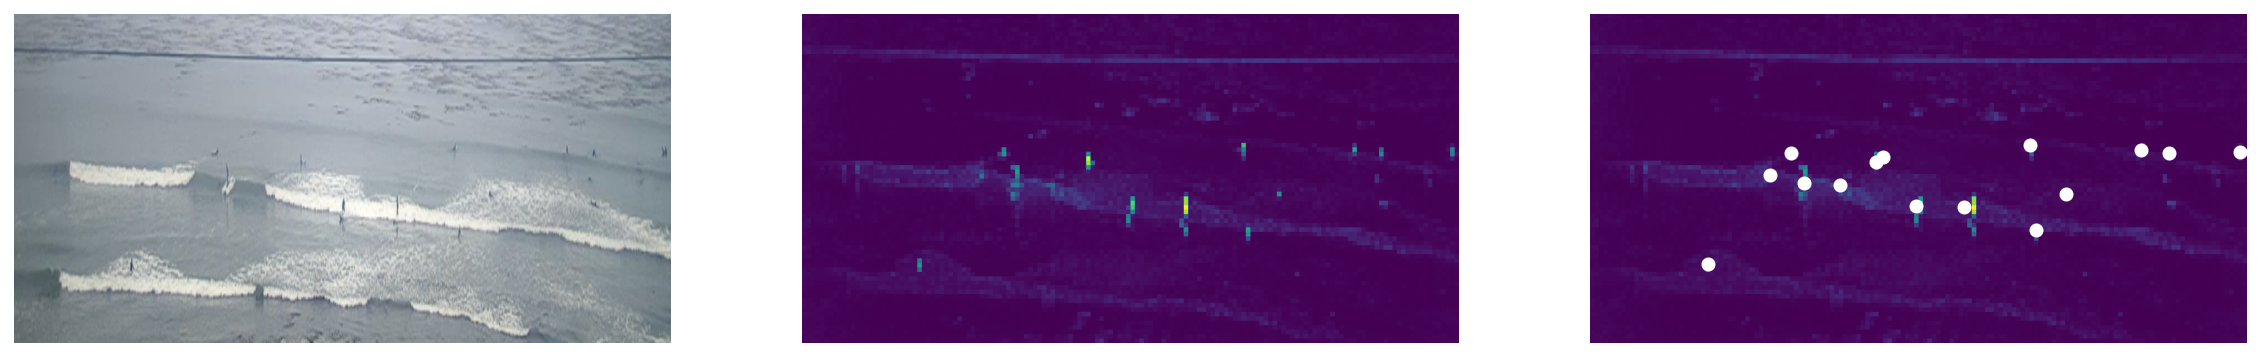

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
axes = axes.flatten()

img = load_image(df.iloc[0].filename, transform=False)
axes[0].imshow(img)
axes[0].axis('off')

axes[1].imshow(heatimg)
axes[1].axis('off')

axes[2].imshow(heatimg)
axes[2].scatter(blobs[:, 1], blobs[:, 0], c='white')
axes[2].axis('off')

plt.show()

In [11]:
preds = []
for i in range(len(df)):
    print(i, end = ' ')
    n,_,_,_ = predict(df.iloc[i], patch_size = patch_size)
    preds.append(n)
    
print(n)
df['surfer count'] = preds
df

0 1 

KeyboardInterrupt: 

In [ ]:
sdf = df.sort_values('time')

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(sdf.time, sdf['surfer count'])